# EDA de correlación de datos y modelo de regresión lineál

In [1]:
# Manejo de archivos
import os
from pathlib import Path

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#datetime
from datetime import datetime, timedelta

In [19]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

## Cargar datos

In [9]:
print(f"Current path: {os.getcwd()}")

Current path: /home/misael/repos/MLOps-grinding/notebooks


In [10]:
# Definir la ruta de los datos
data_path: Path = Path(r"../data/raw")
if not data_path.exists():
    print(f"Path {data_path} does not exits.")

# Imprimir archivos en la carpeta de datos
print(list(data_path.glob("*")))

[PosixPath('../data/raw/datos_molienda.parquet'), PosixPath('../data/raw/datos_molienda (copy).parquet')]


In [11]:
df = pd.read_parquet(data_path / "datos_molienda.parquet")

In [12]:
df.head()

,velocidad,potencia,celda_carga,pad_1,pad_2,pad_3,pad_4,pad_5,pad_6,pad_7,...,in1_5,in1,f80,dureza,per_solidos,wi,spi,imp_criticos,imp_estandares,jb
date,,,,,,,,,,,,,,,,,,,,,
2022-11-15 00:00:00,0.000000,-0.482877,-0.074890,0.816327,-0.794444,-0.545455,0.424731,0.175926,0.515464,0.688525,...,0.465352,0.724886,-0.114582,1.107937,-0.153193,0.246579,0.518816,0.5,0.259414,-1.544362
2022-11-15 00:00:10,0.000000,-0.498288,-0.050831,0.816327,-0.538889,0.831169,0.586022,0.175926,-0.072165,-0.131148,...,0.587188,0.784246,-0.114582,1.107937,-0.227922,0.246579,0.518816,0.5,0.259414,-1.544638
2022-11-15 00:00:20,0.000000,-0.839041,-0.027548,0.843537,-0.538889,0.831169,0.586022,0.888889,0.814433,-0.131148,...,0.587188,0.784246,-0.114582,1.107937,-0.297216,0.246579,0.518816,0.5,0.259414,-1.544928
2022-11-15 00:00:30,0.000000,-0.386986,-0.027548,0.455782,-0.255556,0.077922,0.091398,0.500000,0.814433,-0.172131,...,0.587188,0.784246,-0.303652,1.107937,-0.299254,0.246579,0.518816,0.5,0.259414,-1.545215
2022-11-15 00:00:40,-0.166669,-0.535959,-0.008146,0.455782,0.133333,0.103896,0.000000,0.500000,0.257732,0.008197,...,0.374744,0.478899,-0.313486,1.107937,-0.299254,0.246579,0.518816,0.5,0.259414,-1.545534


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39586 entries, 2022-11-15 00:00:00 to 2022-11-20 00:00:00
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   velocidad       39586 non-null  float64
 1   potencia        39586 non-null  float64
 2   celda_carga     39586 non-null  float64
 3   pad_1           39586 non-null  float64
 4   pad_2           39586 non-null  float64
 5   pad_3           39586 non-null  float64
 6   pad_4           39586 non-null  float64
 7   pad_5           39586 non-null  float64
 8   pad_6           39586 non-null  float64
 9   pad_7           39586 non-null  float64
 10  pad_8           39586 non-null  float64
 11  rendimiento     39586 non-null  float64
 12  flujo_agua      39586 non-null  float64
 13  ruido           39586 non-null  float64
 14  giro            39586 non-null  float64
 15  p80             39586 non-null  float64
 16  in14            39586 non-null  float64
 

In [13]:
df.shape

(39586, 35)

Tenemos 35 variables, la variable objetivo será la `presion`, esta resulta de tomar el promedio de las variables pad1, pad2, ..., pad8 y aplicar un ewm.

In [16]:
df['presion'] = df[['pad_' + str(i) for i in range(1, 9)]].mean(axis = 1)
df[['presion', 'celda_carga']].corr()

,presion,celda_carga
presion,1.000000,0.869691
celda_carga,0.869691,1.000000


La celda de carga y la presión son dos variables que muestran una correlación alta y en la práctica proporcionan información similar sobre el peso del molino en un momento dado. Ambas variables son indicadores importantes para comprender la carga del molino durante su operación.

Sin embargo, observamos que la celda de carga a veces muestra cambios irreales durante la operación del molino. Estos cambios pueden ser especialmente notables durante los procesos de vaciado, donde la celda de carga puede disminuir hasta mil toneladas respecto a su valor anterior. Esta variabilidad puede generar incertidumbre y dificultar la interpretación precisa de la carga del molino. En realidad, se espera que la carga del molino durante estos procesoscaiga aproximadamente entre 200 y 350 toneladas en casos de alta carga. Esto hace que la celda de carga pierda su interpretabilidad de toneladas y se use simplemente como indicador en tendencia, al igual que la preción.

Adicionalmente, la celda de carga tiende a descalibrarse, lo cual hace dificil comparar datos lejanos en tiempo.

Por otro lado, la presión tiende a mostrar un comportamiento más estable y predecible durante la operación del molino, lo que la convierte en un indicador más confiable de la carga del molino en comparación con la celda de carga. Por lo tanto preferimos utilizar la presión como una medida principal de la carga del molino debido a su consistencia y fiabilidad.

Text(0.5, 1.0, 'Relación presión - celda de carga')

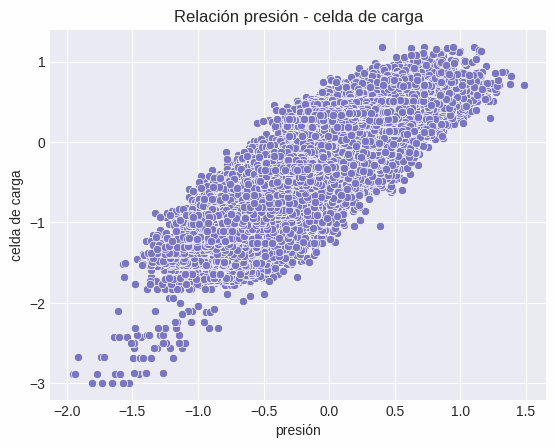

In [22]:
ax = plt.gca()
sns.scatterplot(x = 'presion',
                y = 'celda_carga',
               data = df)
ax.set_xlabel('presión')
ax.set_ylabel('celda de carga')
ax.set_title('Relación presión - celda de carga')

Todos los campos son de tipo **float** y **no** tenemos datos faltantes.

In [29]:
main_folder = Path.cwd().parent / 'data'
main_folder

PosixPath('/home/misael/repos/MLOps-grinding/data')

# Revisión de variables

Como el objetivo del trabajo es desarrollar un modelo que nos permita estimar que tan lleno esta el modelo, nos centraremos en variables que pueden ayudarnos , por su naturaleza a estimarlo.

En general las variables de interes son:
* Velocidad: Entre mas rapido vaya el molino mayor procesamiento de mineral habra y se vaciará con mayor rapidez.
* Potencia: En un rango normal de operación y manteniendo velocidad fija, el molino consumirá mayor energia entre mas lleno este.
* f80: El percentil 80 de granulometría es un buen indicador de que tan grande son las rocas que se le alimentan al molino, las cuales tienen una relacion clara con el tiempo que toma en disminuir su tamaño a un tamaño ideal.

## Outliers

## EDA

<Axes: xlabel='date', ylabel='ruido'>

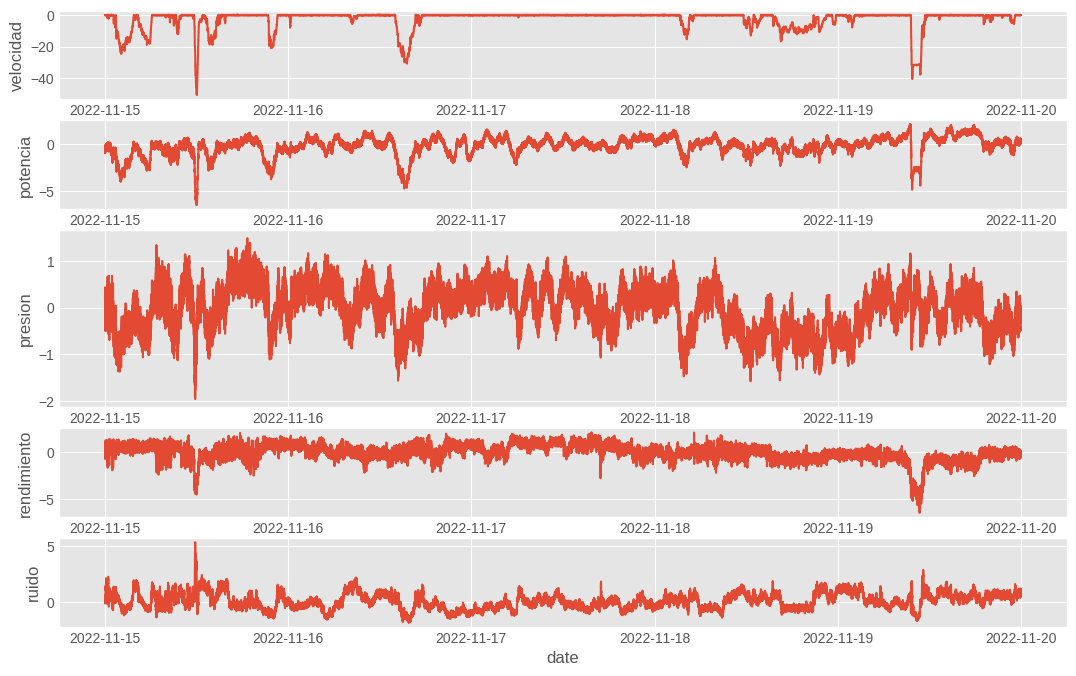

In [86]:
fig, axs = plt.subplots(5, 1, figsize = (13, 8), gridspec_kw = {'height_ratios': [1, 1, 2, 1, 1]})


sns.lineplot(x = 'date',
               y = 'velocidad',
               data = df.reset_index(),
               ax = axs[0])

sns.lineplot(x = 'date',
               y = 'potencia',
               data = df.reset_index(),
               ax = axs[1])

sns.lineplot(x = 'date',
               y = 'presion',
               data = df.reset_index(),
               ax = axs[2])

sns.lineplot(x = 'date',
               y = 'rendimiento',
               data = df.reset_index(),
               ax = axs[3])

sns.lineplot(x = 'date',
               y = 'ruido',
               data = df.reset_index(),
               ax = axs[4])



la velocidad se mantuvo bastante constante durante el tiempo de operación.

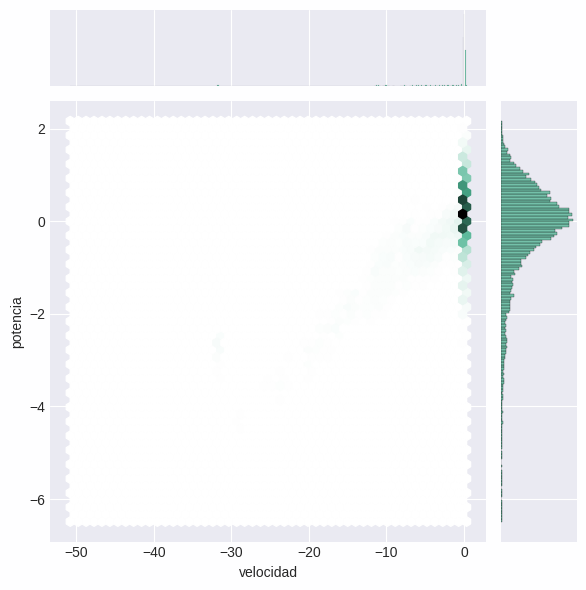

In [34]:
# plt.hexbin(df.velocidad, df.potencia, gridsize=30, cmap='inferno')
sns.jointplot(x='velocidad', y='potencia', kind="hex", color="#4CB391", data = df)


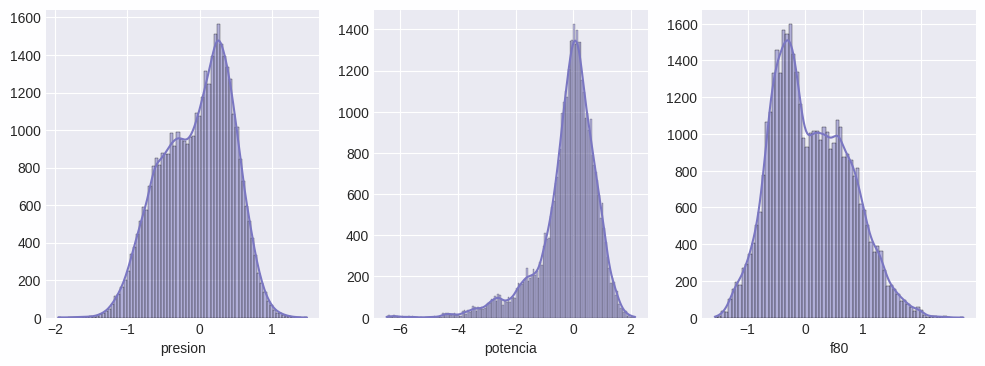

In [56]:
fig, axs = plt.subplots(1, 
                        3,
                        figsize = (12, 4))

sns.histplot(df.presion,
             ax = axs[0],
             kde = True)
sns.histplot(df.potencia,
             ax = axs[1],
             kde = True)
sns.histplot(df.f80,
             ax = axs[2],
             kde = True)

for ax in axs:
    ax.set_ylabel('')

In [66]:
bins_p = df.potencia.quantile([0.2, 0.4,0.6, 0.8, 1]).values
df['cat_potencia'] = pd.cut(df.potencia,
                            bins = bins_p,
                            labels = ['baja', 'media', 'media alta','alta'])

In [68]:
df.describe()

,velocidad,potencia,celda_carga,pad_1,pad_2,pad_3,pad_4,pad_5,pad_6,pad_7,...,in1,f80,dureza,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,...,39586.000000,3.958600e+04,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000
mean,-2.641273,-0.177962,-0.148531,0.016362,-0.019280,0.008693,-0.002362,-0.099917,-0.026502,-0.110781,...,-0.012909,8.889255e-02,0.047403,-0.092907,-1.206076,-0.014318,0.149059,-0.112919,0.037369,-0.031945
std,6.240341,1.028112,0.622128,0.662560,0.654050,0.666522,0.635048,0.682951,0.699058,0.680216,...,0.712906,6.628216e-01,0.740109,0.564308,9.163868,0.920594,0.837313,0.776966,0.678315,0.483455
min,-50.782181,-6.484589,-2.996126,-2.292517,-1.944444,-2.149351,-1.677419,-2.962963,-2.484536,-3.368852,...,-3.210599,-1.567903e+00,-1.056575,-1.842223,-71.123548,-4.947649,-1.211538,-3.217573,-1.550769,-1.953669
25%,-1.000000,-0.542808,-0.626697,-0.476190,-0.522222,-0.480519,-0.505376,-0.601852,-0.515464,-0.598361,...,-0.549290,-4.198125e-01,-0.433487,-0.590694,-0.545249,-0.506949,-0.442308,-0.535565,-0.468965,-0.398925
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.919452e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032961
75%,0.000000,0.457192,0.373303,0.523810,0.477778,0.519481,0.494624,0.398148,0.484536,0.401639,...,0.450710,5.801875e-01,0.566513,0.409306,0.454751,0.493051,0.557692,0.464435,0.531035,0.339543
max,0.333322,2.160959,1.183942,1.863946,1.961111,1.824675,1.854839,1.935185,2.164948,1.860656,...,2.374983,2.731476e+00,1.107937,1.555706,1.997031,2.010629,9.653846,2.221757,1.638403,1.483654


In [72]:
plt.style.use('ggplot')

<Axes: xlabel='celda_carga', ylabel='Count'>

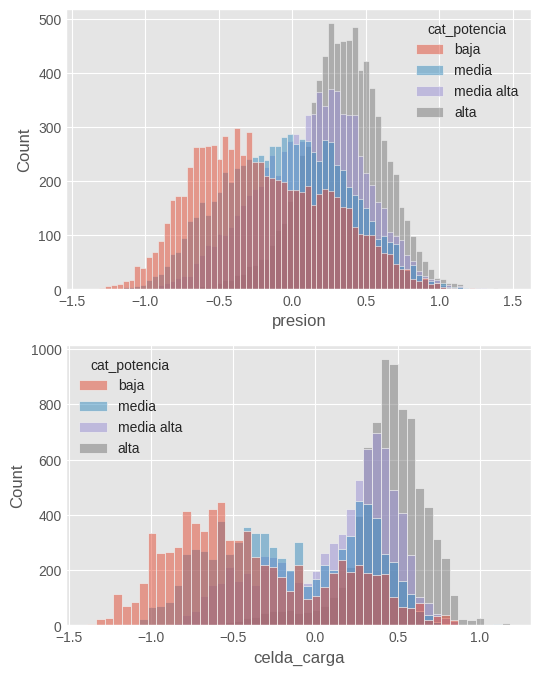

In [83]:
fig, axs = plt.subplots(2, 1, figsize = (6, 8))

sns.histplot(x = 'presion',
             hue = 'cat_potencia',
             data = df,
             ax = axs[0])

sns.histplot(x = 'celda_carga',
             hue = 'cat_potencia',
             data = df,
             ax= axs[1])

In [93]:
df.columns

Index(['velocidad', 'potencia', 'celda_carga', 'pad_1', 'pad_2', 'pad_3',
       'pad_4', 'pad_5', 'pad_6', 'pad_7', 'pad_8', 'rendimiento',
       'flujo_agua', 'ruido', 'giro', 'p80', 'in14', 'in12', 'in10', 'in8',
       'in6', 'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza',
       'per_solidos', 'wi', 'spi', 'imp_criticos', 'imp_estandares', 'jb',
       'presion', 'cat_potencia'],
      dtype='object')

<Axes: >

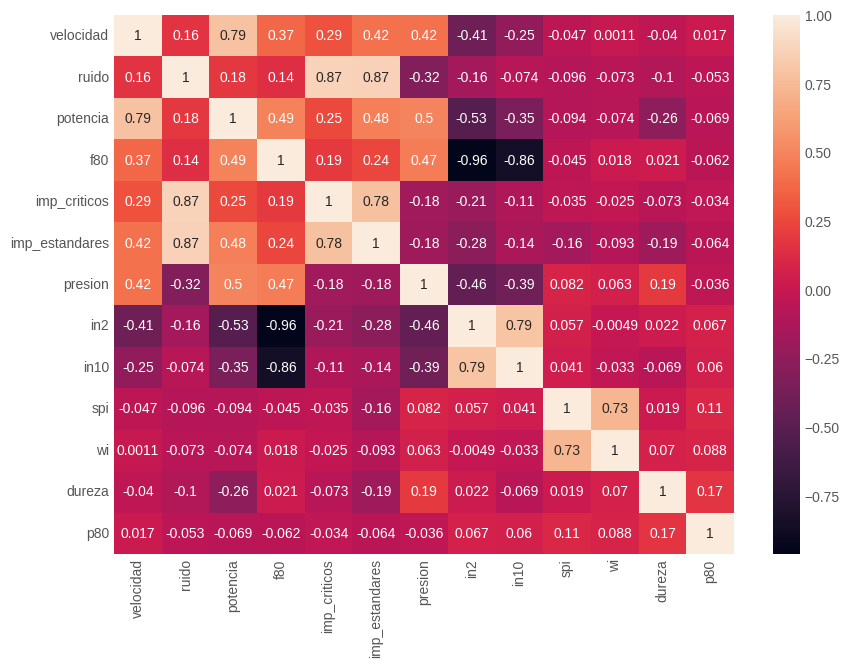

In [118]:
fig, ax = plt.subplots(figsize = (10, 7))

vars_interes = ['velocidad', 'ruido', 'potencia', 'f80', 'imp_criticos', 'imp_estandares', 'presion','in2', 'in10', 'spi', 'wi', 'dureza', 'p80']
sns.heatmap(df[vars_interes].corr(),
            annot = True)

<Axes: >

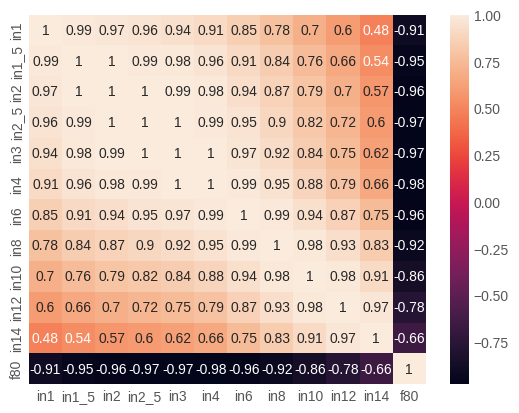

In [110]:
# correlacion entre granulometrias
vars_ = ['in1', 'in1_5', 'in2', 'in2_5', 'in3', 'in4', 'in6', 'in8', 'in10', 'in12', 'in14', 'f80']
sns.heatmap(df[vars_].corr(),
            annot = True)

## 

# Transformación datos a intervalo

La frecuencia de datos debe ser 10 segundos, sin embargo es normal que haya perdida de datos, siempre que estos tenga una diferencia pequeña en tiempo se pueden rellenar


## Rellenos de datos faltantes

In [105]:
df.reset_index().date.diff().value_counts()

date
0 days 00:00:10    43192
0 days 00:01:20        1
Name: count, dtype: int64

In [106]:
#los datos con separación de 20 y 30 segundos se llenenan con un ff
df = df.asfreq('10s')
df = df.ffill(limit = 2) #rellenar a lo máximo 30 segundos
df = df.dropna(how = 'all')
df.reset_index().date.diff().value_counts()

date
0 days 00:00:10    43194
0 days 00:01:00        1
Name: count, dtype: int64

## Data set de intervalos 5 minutos, con variable objetivo

In [108]:
df.columns

Index(['velocidad', 'potencia', 'celda_carga', 'pad_1', 'pad_2', 'pad_3',
       'pad_4', 'pad_5', 'pad_6', 'pad_7', 'pad_8', 'rendimiento',
       'flujo_agua', 'ruido', 'giro', 'p80', 'in14', 'in12', 'in10', 'in8',
       'in6', 'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza',
       'per_solidos', 'wi', 'spi', 'imp_criticos', 'imp_estandares', 'jb',
       'presion', 'cat_potencia'],
      dtype='object')

In [124]:
df_model = pd.DataFrame(columns = ['velocidad', # promedio
                                   'potencia', # de instante
                                  'rendimiento',#promedio
                                 'ruido',  #de instante
                                  'p80', #promedio
                                  'in14', #promedio
                                   'f80', #promedio
                                   'per_solidos', #promedio
                                    'wi', #promedio
                                 'spi', #promedio
                                 'imp_criticos', #promedio
                                 'imp_estandares', #promedio
                                 'presion', # de instante
                                 ],
                          index = pd.to_datetime([]))
df_model

,velocidad,potencia,rendimiento,ruido,p80,in14,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,presion


In [130]:
for date in df.index:
    #falta ignorar los intervalos con datos perdidos
    delta5 = timedelta(minutes = 5)
    ini = date - delta5
    fin = date
    velocidad = df.loc[ini:fin, 'velocidad'].mean()
    potencia = df.loc[fin, 'potencia']
    rendimiento = df.loc[ini:fin, 'rendimiento'].mean()
    ruido = df.loc[fin, 'ruido']
    p80 = df.loc[ini:fin, 'p80'].mean()
    in14 = f80 = df.loc[ini:fin, 'in14'].mean()
    f80 = df.loc[ini:fin, 'f80'].mean()
    per_solidos = df.loc[ini:fin, 'per_solidos'].mean()
    wi = df.loc[ini:fin, 'wi'].mean()
    spi = df.loc[ini:fin, 'spi'].mean()
    imp_criticos = df.loc[ini:fin, 'imp_criticos'].mean()
    imp_estandares = df.loc[ini:fin, 'imp_estandares'].mean()
    presion = df.loc[fin, 'presion']
    df_model.loc[date, :] = (velocidad, potencia, rendimiento, ruido, p80, in14, f80, per_solidos, wi, spi, imp_criticos, imp_estandares, presion)
    

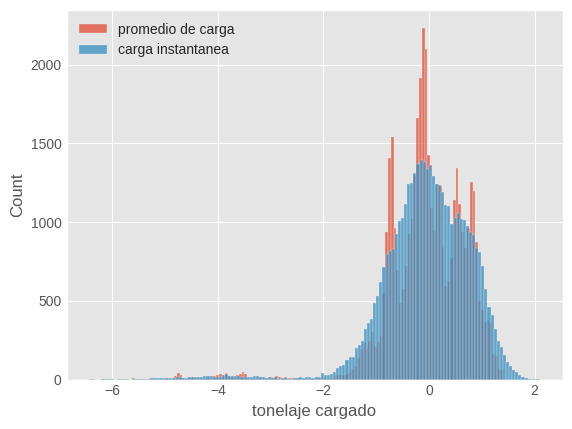

In [136]:
ax = plt.gca()
sns.histplot(df_model.rendimiento,
             label = 'promedio de carga')
sns.histplot(df.rendimiento,
             label = 'carga instantanea')
ax.set_xlabel('tonelaje cargado')
ax.legend()

<Axes: xlabel='rendimiento', ylabel='potencia'>

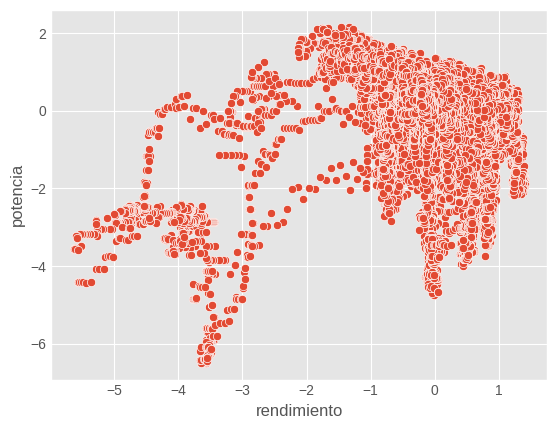

In [147]:
sns.scatterplot(x = 'rendimiento',
                y = 'potencia',
                data = df_model)